In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from pylab import rcParams

%matplotlib inline

rcParams['figure.figsize'] = 12, 6

RANDOM_SEED = 56

np.random.seed(RANDOM_SEED)

from matplotlib import rc
rc('animation', html='jshtml')

# Data and plotting

Code to randomly generate random, linearly separable training data 

In [0]:
def generateData(n):
  """ 
  Create two Gaussians that (probably) do not overlap.
  """
  # sample 2D points from each Gaussian
  classA = np.random.multivariate_normal([1.0, 1.0],
                                         [[0.1, 0.0], [0.0, 0.5]],
                                         n//2)
  
  classB = np.random.multivariate_normal([-1.0, 1.0],
                                         [[0.1, 0.0], [0.0, 0.5]],
                                         n//2)
  X = np.concatenate([classA, classB], axis=0)
  
  # create the labels (1 and 0)
  labelsA = np.ones([n//2, 1])
  labelsB = np.zeros([n//2, 1])
  labels = np.concatenate([labelsA, labelsB], axis=0)
  
  # add a 1 for the bias term
  bias = np.ones([n, 1])
  
  # put everything together
  data = np.concatenate([bias, X, labels], axis=-1)
  return data


def plotData(data, w, idx=None):
  """
  Plot the data points and the separating hyperplane. If `idx` is given
  this data point is highlighted.
  """
  plt.clf()
  plt.axis([-2.5,2.5,-2.5,4.0])
  for i,x in enumerate(data):
    plt.plot(x[1], x[2], 'ob' if (x[3] > 0.0) else 'or')
    if idx is not None and idx == i:
      plt.plot(x[1], x[2], 'og', markersize=15)
  plotHyperPlane(w)

  
def plotHyperPlane(w):
  """
  Plot the hyperplane and shade each side according to its class.
  """
  b = w[0]
  m = -w[1] / w[2]
  c = -b / w[2]
  x = np.array([-3, 3])
  y = np.array([-3*m + c, 3*m + c])
  p1 = plt.plot(x, y,'--k')[0]
  
  plt.fill_between(x, y, 4*np.sign(w[2]), interpolate=True, color='b', alpha=0.25)
  plt.fill_between(x, y, -4*np.sign(w[2]), interpolate=True, color='r', alpha=0.25)
  
  return p1

# Perceptron class

In [0]:
class Perceptron:
  def __init__(self):
    """ perceptron initialization """
     # initialize weights; here set to rbitrary value so the decision boundary can be rendered during the first iteration
    self.w = np.array([0.2, -0.1, -0.1])
    self.learningRate = 0.1
    self.maxIterations = 100

  def prediction(self,x):
    """
    perceptron output 
    (w^Tx > 0) => 1 else 0 
    """
    f = np.dot(self.w, x[:3]) 
    return 1.0 if f > 0.0 else 0.0

  def updateWeights(self,x,residual):
    """
    updates the weights via update rule:
    w(t+1) = w(t) + learningRate*(y-yhat)*x
    """
    self.w += self.learningRate*residual*x[:3]
  
  def train(self,data):
    """ 
    Every vector in data must have three elements (bias,data),
    the forth element (x[3]) must be the label (desired output)
    """
    iteration = 0
    weights = [(None, np.copy(self.w))]  # used for visualization only 
    while iteration < self.maxIterations:
      globalError = 0.0
      
      for i, x in enumerate(data):  # for each sample
        yhat = self.prediction(x)
        residual = x[3] - yhat
        if abs(residual) > 0.0:  # if the prediction is wrong
          self.updateWeights(x, residual)
          print('index ', i, ' prediction ', yhat, ' label ', x[3], ' residual ', residual)
          weights.append((i, np.copy(self.w)))  # store intermediate weights for visualization
          globalError += abs(residual)
          break  # not strictly necessary, makes iteration count consistent
      
      iteration += 1
  
      if globalError == 0.0:  # stopping criteria
        print('stopped after {} iterations'.format(iteration))
        weights.append((None, np.copy(self.w)))  # store final weights for visualization
        return weights
    
    print('did not converge after {} iterations'.format(iteration))
    return weights

# Testing
Generate random train and test set then train a perceptron

index  0  prediction  0.0  label  1.0  residual  1.0
index  150  prediction  1.0  label  0.0  residual  -1.0
index  113  prediction  0.0  label  1.0  residual  1.0
index  150  prediction  1.0  label  0.0  residual  -1.0
index  150  prediction  1.0  label  0.0  residual  -1.0
stopped after 6 iterations


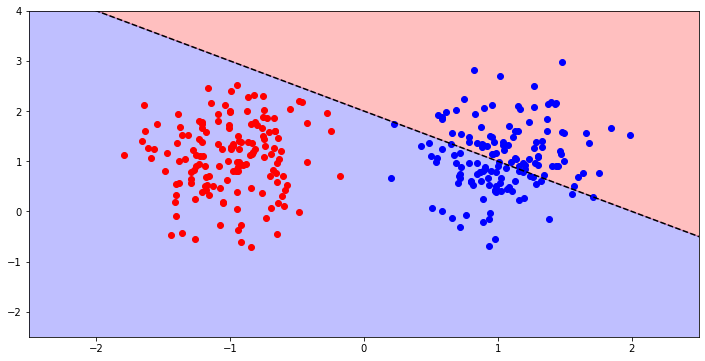

In [0]:
trainset = generateData(300)  # train set generation
perceptron = Perceptron()
plotData(trainset, perceptron.w)
weights = perceptron.train(trainset)  # training

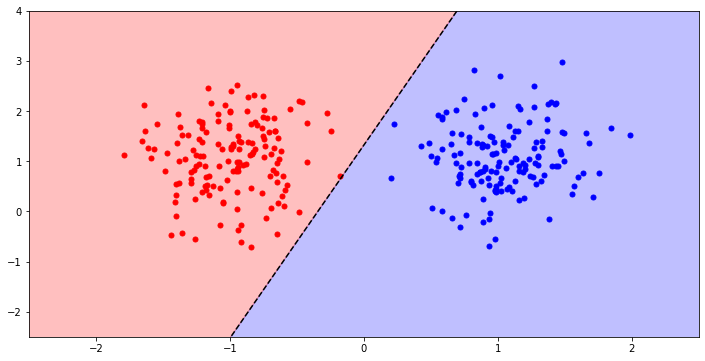

In [0]:
# animate the training progress
fig = plt.figure()
plt.axis([-2.5,2.5,-2.5,4.0])

# get point and line objects that we want to animate
all_points = []
for i, x in enumerate(trainset):
  p, = plt.plot(x[1], x[2], 'ob' if (x[3] > 0.0) else 'or')
  all_points.append(p)
  
hyperplane = plotHyperPlane(weights[0][1])

# update function that is running every loop
def animate(num, points, hyperplane, data, idx_and_weights):
  # get weights and error point index for current frame
  idx, w = idx_and_weights[num]
  
  # plot the data, highlighting the point that updated the plane
  for i, p in enumerate(points):
    c = 'b' if (data[i][3] == 1.0) else 'r'
    p.set_color(c)
    p.set_markersize(5)
    if idx is not None and idx == i:
      p.set_color('g')
      p.set_markersize(15)
      
  # update location of hyperplane
  w = w / np.linalg.norm(w)
  b = w[0]
  m = -w[1] / w[2]
  c = -b / w[2]
  x = np.array([-3, 3])
  y = np.array([-3*m + c, 3*m + c])
  hyperplane.set_data(np.array([x, y]))
  
  # update background shading
  ax = fig.axes[0]
  ax.collections.clear()
  ax.fill_between(x, y, 4*np.sign(w[2]), interpolate=True, color='b', alpha=0.25)
  ax.fill_between(x, y, -4*np.sign(w[2]), interpolate=True, color='r', alpha=0.25)
  
  return points
      
anim = animation.FuncAnimation(fig, animate, frames=len(weights),
                               fargs=(all_points, hyperplane, trainset, weights),
                               interval=1000, blit=True)

rc('animation', html='jshtml')
anim

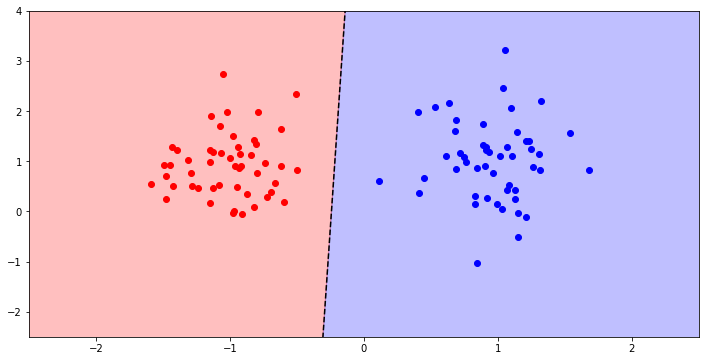

In [0]:
testset = generateData(100)  # test set generation
plotData(testset, perceptron.w)

# print if there are any errors
for x in testset:
  r = perceptron.prediction(x)
  if np.abs(r - x[3]) > 0.0:
    print('error')